<a href="https://colab.research.google.com/github/SunnyS8/-/blob/main/RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузите файл Excel...


Saving Копия Пример данных для тестового RFM анализа.xlsx to Копия Пример данных для тестового RFM анализа (3).xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Выручка по сегментам:
                                   segment    Monetary
0  лояльные клиенты, потерявшие активность  9847920.48
1                  лояльные спящие клиенты  3065100.40
7                                   спящие  2841930.10
3                                  новички  1945840.76
6                            развивающиеся   812026.68
5                               потерянные   673110.12
4                               постоянные   467129.40
2                           неопределенный    59515.84


<ipython-input-4-29f53b97a622>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=revenue_by_segment, x='Monetary', y='segment', palette='viridis')


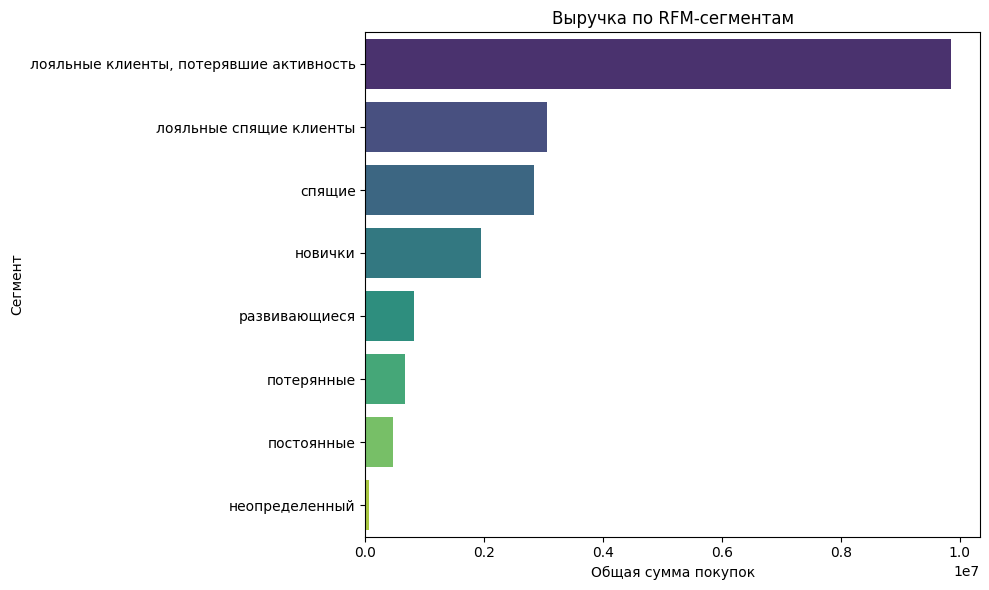

In [4]:
# Шаг 1: Импорт библиотек
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Шаг 2: Загрузка файла
print("Загрузите файл Excel...")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Чтение двух листов
df_clients = pd.read_excel(file_name, sheet_name=0)
df_employees = pd.read_excel(file_name, sheet_name=1)
# Шаг 3: Очистка данных
# Убираем запятые и приводим Monetary к float
df_clients['Monetary'] = df_clients['Monetary'].astype(str).str.replace(',', '').astype(float)

# Шаг 4: Присвоение рангов R, F, M (робастный способ)
def safe_qcut(series, q):
    try:
        return pd.qcut(series, q=q, duplicates='drop').cat.codes + 1
    except:
        print(f"qcut не сработал для {series.name}, используется cut")
        return pd.cut(series, bins=q).cat.codes + 1

df_clients['R'] = safe_qcut(df_clients['recency'], q=3)
df_clients['F'] = safe_qcut(df_clients['frequency'], q=3)
df_clients['M'] = safe_qcut(df_clients['Monetary'], q=3)

# Шаг 5: Классификация клиентов по сегментам
def classify_segment(row):
    r, f, m = row['R'], row['F'], row['M']

    if r == 1 and f == 1:
        return "потерянные"
    elif r == 1 and f in [2, 3]:
        return "лояльные клиенты, потерявшие активность"
    elif r == 2 and f in [1, 2]:
        return "спящие"
    elif r == 2 and f == 3:
        return "лояльные спящие клиенты"
    elif r == 3 and f == 1:
        return "новички"
    elif r == 3 and f == 2:
        return "развивающиеся"
    elif r == 3 and f == 3 and m == 3:
        return "постоянные"
    else:
        return "неопределенный"

df_clients['segment'] = df_clients.apply(classify_segment, axis=1)

# Шаг 6: Отметка сотрудников
employee_ids = set(df_employees['id'])
df_clients['is_employee'] = df_clients['id'].apply(lambda x: x in employee_ids)

# Шаг 7: Сохранение результата в Excel
output_file = 'rfm_analysis_result.xlsx'
df_clients.to_excel(output_file, index=False)
files.download(output_file)

# Шаг 8: Выручка по сегментам
revenue_by_segment = df_clients.groupby('segment')['Monetary'].sum().reset_index()
revenue_by_segment = revenue_by_segment.sort_values(by='Monetary', ascending=False)

# Вывод сводной таблицы
print("\nВыручка по сегментам:")
print(revenue_by_segment)

# Шаг 9: Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=revenue_by_segment, x='Monetary', y='segment', palette='viridis')
plt.title('Выручка по RFM-сегментам')
plt.xlabel('Общая сумма покупок')
plt.ylabel('Сегмент')
plt.tight_layout()
plt.show()

# Шаг 10: Дополнительно — можно сохранить в Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# df_clients.to_excel('/content/drive/MyDrive/rfm_analysis_final.xlsx', index=False)